In [ ]:
pip install dwave-ocean-sdk>=3.3.0 matplotlib dwave-system

In [ ]:
# Setup your D-Wave Leap API
!dwave config create --auto-token

Using the simplified configuration flow.
Try 'dwave config create --full' for more options.

Creating new configuration file: /root/.config/dwave/dwave.conf
Updating existing profile: defaults
Failed to fetch SAPI token from Leap API (Leap API access token not found. Please run "dwave auth login".).
Solver API token [skip]: DEV-e0718a8fea398b4ee4c3c795cf0425f82d372dd8
Configuration saved.


In [11]:
import random
import argparse
import dimod
import sys
import networkx as nx
import numpy as np
from dwave.system import LeapHybridSampler

import matplotlib
try:
    import matplotlib.pyplot as plt
except ImportError:
    matplotlib.use("agg")
    import matplotlib.pyplot as plt

def set_up_scenario(w, h, num_poi, num_existing_macros, netlist):
    """Build scenario set up with specified parameters.

    Args:
        w (int): Width of grid
        h (int): Height of grid
        num_poi (int): Number of points of interest
        num_existing_macros (int): Number of existing macro
        netlist (list of tuples): List of connections (edges) between nodes

    Returns:
        G (networkx graph): Grid graph of size w by h with specified netlist
        pois (list of tuples of ints): A fixed set of points of interest
        macro (list of tuples of ints):
            Set of current macro locations
        location_potential_new_macros (list of tuples of ints):
            Potential new macro locations
    """

    G = nx.grid_2d_graph(w, h)
    nodes = list(G.nodes)

    # Add netlist connections
    G.add_edges_from(netlist)

    # Identify a fixed set of points of interest
    pois = random.sample(nodes, k=num_poi)

    # Identify a fixed set of current macro locations
    location_existing_macros = random.sample(nodes, k=num_existing_macros)

    # Identify potential new macro locations
    location_potential_new_macros = list(G.nodes() - location_existing_macros)

    return G, pois, location_existing_macros, location_potential_new_macros

def manhattan_distance(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def build_bqm(location_potential_new_macros, num_poi, pois, num_existing_macros, location_existing_macros, num_new_macros, netlist):
    """Build bqm that models our problem scenario for the hybrid sampler.

    Args:
        location_potential_new_macros (list of tuples of ints):
            Potential new macro locations
        num_poi (int): Number of points of interest
        pois (list of tuples of ints): A fixed set of points of interest
        num_existing_macros (int): Number of existing macro
        location_existing_macros (list of tuples of ints):
            Set of current macro locations
        num_new_macros (int): Number of new macro desired
        netlist (list of tuples): List of connections (edges) between nodes

    Returns:
        bqm_np (BinaryQuadraticModel): QUBO model for the input scenario
    """

    # Tunable parameters
    gamma1 = len(location_potential_new_macros) * 4
    gamma2 = len(location_potential_new_macros) / 3
    gamma3 = len(location_potential_new_macros) * 1.7
    gamma4 = len(location_potential_new_macros) ** 3

    # Build BQM using adjVectors to find best new macro location s.t. min
    # distance to POIs and max distance to existing macro locations
    bqm = dimod.BinaryQuadraticModel(len(location_potential_new_macros), 'BINARY')

    # Constraint 1: Min average distance to POIs
    if num_poi > 0:
        for i in range(len(location_potential_new_macros)):
            # Compute average distance to POIs from this node
            cand_loc = location_potential_new_macros[i]
            avg_dist = sum(manhattan_distance(cand_loc, loc) for loc in pois) / num_poi
            bqm.linear[i] += avg_dist * gamma1

    # Constraint 2: Max distance to existing macros
    if num_existing_macros > 0:
        for i in range(len(location_potential_new_macros)):
            # Compute average distance to POIs from this node
            cand_loc = location_potential_new_macros[i]
            avg_dist = -sum(manhattan_distance(cand_loc, loc)
                            for loc in location_existing_macros) / num_existing_macros
            bqm.linear[i] += avg_dist * gamma2

    # Constraint 3: Max distance to other new macro locations
    if num_new_macros > 1:
        for i in range(len(location_potential_new_macros)):
            for j in range(i+1, len(location_potential_new_macros)):
                ai = location_potential_new_macros[i]
                aj = location_potential_new_macros[j]
                dist = -manhattan_distance(ai, aj)
                bqm.add_interaction(i, j, dist * gamma3)

    # Netlist constraint: Connect nodes in netlist should be placed closer
    for (i, j) in netlist:
        if i in location_potential_new_macros and j in location_potential_new_macros:
            idx_i = location_potential_new_macros.index(i)
            idx_j = location_potential_new_macros.index(j)
            bqm.add_interaction(idx_i, idx_j, -manhattan_distance(i, j) * gamma3)

    # Constraint 4: Choose exactly num_new_macros new macro locations
    bqm.update(dimod.generators.combinations(bqm.variables, num_new_macros, strength=gamma4))

    return bqm

def run_bqm_and_collect_solutions(bqm, sampler, location_potential_new_macros, **kwargs):
    """Solve the bqm with the provided sampler to find new macro locations.

    Args:
        bqm (BinaryQuadraticModel): The QUBO model for the problem instance
        sampler: Sampler or solver to be used
        location_potential_new_macros (list of tuples of ints):
            Potential new macro locations
        **kwargs: Sampler-specific parameters to be used

    Returns:
        new_macro_nodes (list of tuples of ints):
            Locations of new macro
    """

    sampleset = sampler.sample(bqm,
                               label='Example - Macro Placement',
                               **kwargs)

    ss = sampleset.first.sample
    new_macro_nodes = [location_potential_new_macros[k] for k, v in ss.items() if v == 1]

    return new_macro_nodes

def printout_solution_to_cmdline(pois, num_poi, macro, num_existing_macros, new_macro_nodes, num_new_macros):
    """Print solution statistics to command line.

    Args:
        pois (list of tuples of ints): A fixed set of points of interest
        num_poi (int): Number of points of interest
        macro (list of tuples of ints):
            A fixed set of current macro locations
        num_existing_macros (int): Number of existing macro
        new_macro_nodes (list of tuples of ints):
            Locations of new macro
        num_new_macros (int): Number of new macro desired

    Returns:
        None.
    """

    print("\nSolution returned: \n------------------")

    print("\nNew macro locations:\t\t\t\t", new_macro_nodes)

    if num_poi > 0:
        poi_avg_dist = [0] * len(new_macro_nodes)
        for loc in pois:
            for i, new in enumerate(new_macro_nodes):
                poi_avg_dist[i] += sum(abs(a - b) for a, b in zip(new, loc)) / num_poi
        print("Average distance to POIs:\t\t\t", poi_avg_dist)

    if num_existing_macros > 0:
        old_cs_avg_dist = [sum(abs(a - b) for a, b in zip(new, loc) for loc in macro) / num_existing_macros for new in new_macro_nodes]
        print("Average distance to old macro:\t", old_cs_avg_dist)

    if num_new_macros > 1:
        new_cs_dist = 0
        for i in range(num_new_macros):
            for j in range(i+1, num_new_macros):
                new_cs_dist += abs(new_macro_nodes[i][0]-new_macro_nodes[j][0])+abs(new_macro_nodes[i][1]-new_macro_nodes[j][1])
        print("Distance between new macros:\t\t\t", new_cs_dist)

def save_output_image(G, pois, location_existing_macros, location_new_macros):
    """ Create output image of solution scenario.
            - Black nodes: available space
            - Red nodes: current macros location
            - Nodes marked 'P': POI locations
            - Blue nodes: new macro locations

    Args:
        G (networkx graph): Grid graph of size w by h
        pois (list of tuples of ints): A fixed set of points of interest
        macro (list of tuples of ints):
            A fixed set of current macro locations
        new_macro_nodes (list of tuples of ints):
            Locations of new macro

    Returns:
        None. Output saved to file "map.png".
    """

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('New macro locations')
    pos = {x: [x[0],x[1]] for x in G.nodes()}

    # Locate POIs in map
    poi_graph = G.subgraph(pois)
    poi_labels = {x: 'P' for x in poi_graph.nodes()}

    # Locate old macro in map
    cs_graph = G.subgraph(location_existing_macros)

    # Locate old macro at POIs in map
    poi_cs_list = set(pois) - (set(pois)-set(location_existing_macros))
    poi_cs_graph = G.subgraph(poi_cs_list)
    poi_cs_labels = {x: 'P' for x in poi_graph.nodes()}

    # Draw old map (left image)
    nx.draw_networkx(G, ax=ax1, pos=pos, with_labels=False, node_color='k', font_color='w')
    nx.draw_networkx(poi_graph, ax=ax1, pos=pos, with_labels=True,
                        labels=poi_labels, node_color='k', font_color='w')
    nx.draw_networkx(cs_graph, ax=ax1, pos=pos, with_labels=False, node_color='r',
                        font_color='k')
    nx.draw_networkx(poi_cs_graph, ax=ax1, pos=pos, with_labels=True,
                        labels=poi_cs_labels, node_color='r', font_color='w')

    # Draw new map (right image)
    new_cs_graph = G.subgraph(location_new_macros)
    nx.draw_networkx(G, ax=ax2, pos=pos, with_labels=False, node_color='k',
                        font_color='w')
    nx.draw_networkx(poi_graph, ax=ax2, pos=pos, with_labels=True,
                        labels=poi_labels,node_color='k', font_color='w')
    nx.draw_networkx(cs_graph, ax=ax2, pos=pos, with_labels=False, node_color='r',
                        font_color='k')
    nx.draw_networkx(poi_cs_graph, ax=ax2, pos=pos, with_labels=True,
                        labels=poi_cs_labels,  node_color='r', font_color='w')
    nx.draw_networkx(new_cs_graph, ax=ax2, pos=pos, with_labels=False,
                        node_color='#00b4d9', font_color='w')

    # Save image
    plt.savefig("map.png")


Running scenario on hybrid_binary_quadratic_model_version2 solver...

Solution returned: 
------------------

New macro locations:				 [(25, 28), (3, 4), (5, 22), (20, 15), (11, 2), (16, 20), (16, 24), (16, 1)]
Average distance to POIs:			 [21.4, 24.599999999999998, 15.4, 12.2, 22.6, 12.4, 14.8, 24.6]
Average distance to old macro:	 [25.0, 21.0, 7.0, 15.0, 19.0, 8.0, 12.0, 25.0]
Distance between new macros:			 602


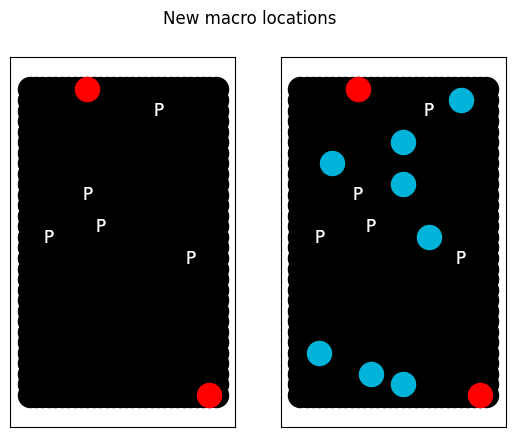

In [12]:

# Define the netlist
netlist = [((1, 1), (2, 2)), ((2, 2), (3, 3)), ((4, 4), (5, 5))]

width = 30
height = 30
poi = 5
num_existing_macros = 2
num_new_macros = 8

G, pois, location_existing_macros, location_potential_new_macros = set_up_scenario(width, height, poi, num_existing_macros, netlist)
bqm = build_bqm(location_potential_new_macros, poi, pois, num_existing_macros, location_existing_macros, num_new_macros, netlist)
sampler = LeapHybridSampler()
print("\nRunning scenario on", sampler.solver.id, "solver...")
location_new_macros = run_bqm_and_collect_solutions(bqm, sampler, location_potential_new_macros)
printout_solution_to_cmdline(pois, poi, location_existing_macros, num_existing_macros, location_new_macros, num_new_macros)
save_output_image(G, pois, location_existing_macros, location_new_macros)
